In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import statsmodels.api as sm
from scipy.stats import norm, t
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import datetime 

%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


In [2]:
df = pd.read_csv('sales_train.csv')

In [4]:
df.count()

date              2935849
date_block_num    2935849
shop_id           2935849
item_id           2935849
item_price        2935849
item_cnt_day      2935849
dtype: int64

In [15]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [20]:
df['date']= pd.to_datetime(df['date'])
df['item_cnt_day'] = int(df['item_cnt_day'])

TypeError: cannot convert the series to <class 'int'>

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


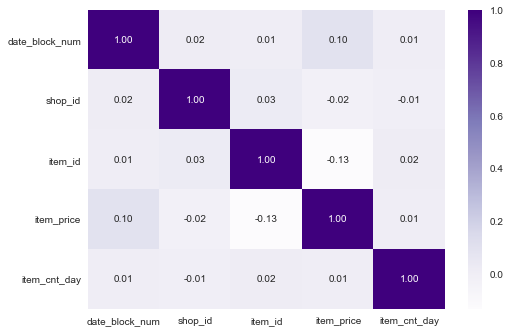

In [17]:
sns.heatmap(df.corr(), annot=True, fmt='0.2f', cmap='Purples')

In [18]:
df.corr()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019273,0.009356,0.095010,0.009402
shop_id,0.019273,1.000000,0.029396,-0.024034,-0.005230
item_id,0.009356,0.029396,1.000000,-0.134104,0.016650
item_price,0.095010,-0.024034,-0.134104,1.000000,0.011197
item_cnt_day,0.009402,-0.005230,0.016650,0.011197,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb91baa20a0>,
      dtype=object)

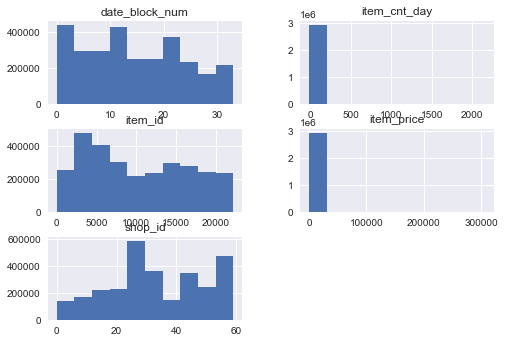

In [19]:
df.hist()